In [38]:
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

from hmmlearn import hmm
from sklearn.metrics import aic

import os

ImportError: cannot import name 'aic' from 'sklearn.metrics' (/opt/homebrew/Caskroom/miniconda/base/envs/tradingstrats/lib/python3.8/site-packages/sklearn/metrics/__init__.py)

## Read data from ticker

In [2]:
df = pd.read_csv('../data/aggregate/idx30.csv', delimiter=";", index_col=0)
filtered_colnames = [col[:4] for col in df.columns.tolist() if "Unnamed" not in col]

df = pd.read_csv('../data/aggregate/idx30.csv', delimiter=";", header=1, index_col=0)
df = df[pd.to_datetime(df.index, errors="coerce").notna()]

# Split the dataframe into adjusted close prices and volumes
adj_close_cols = [col for col in df.columns if 'PX_LAST' in col]
volume_cols = [col for col in df.columns if 'VOLUME' in col]

# Create separate dataframes
df_adj_close = df[adj_close_cols].apply(pd.to_numeric, errors='coerce')
df_volume = df[volume_cols].apply(pd.to_numeric, errors='coerce')

df_adj_close.index = pd.to_datetime(df_adj_close.index)
df_adj_close.columns = filtered_colnames
df_volume.index = pd.to_datetime(df_volume.index)
df_volume.columns = filtered_colnames

# Now resample the data to weekly frequency
df_adj_close_weekly = df_adj_close.resample('W').last().sort_index(ascending=False)

# Check earliest non NaN dates for each ticker
# earliest_dates = df_adj_close_weekly.apply(lambda x: x.dropna().index.min())



# SET CUTOFF DATE and cut to view the most recent data
date_threshold = pd.to_datetime('2010-10-10')
df_after = df_adj_close_weekly[df_adj_close_weekly.index >= date_threshold].dropna(axis=1) 

In [3]:
df_after

,ACES,ASII,ICBP,SMGR,ADRO,BBCA,INCO,MEDC,TLKM,AKRA,...,AMRT,BBRI,INKP,UNVR,ANTM,BMRI,ITMG,BRPT,KLBF,PTBA
Type,,,,,,,,,,,,,,,,,,,,,
2024-08-04,800,4630,10925.0,3910,3230,10325,3700,1310,2890,1515,...,2850,4670,8200,2430,1305,6425,26100,1095,1565,2660
2024-07-28,820,4610,10850.0,4010,3180,10325,3740,1325,3100,1555,...,2850,4760,8075,2490,1295,6550,26400,1065,1575,2660
2024-07-21,800,4530,10800.0,4060,3100,10125,3840,1285,3140,1515,...,2880,4900,8500,2800,1350,6525,26525,1055,1575,2630
2024-07-14,800,4540,10375.0,4090,2830,10075,3750,1315,3220,1500,...,2930,4900,8450,2920,1360,6425,25550,1130,1560,2530
2024-07-07,835,4580,10275.0,3950,2910,9950,4040,1390,3020,1565,...,2780,4800,8850,2910,1310,6425,26150,1220,1490,2540
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2010-11-07,270,5670,2600.0,9274,2275,1420,4683,737,1570,310,...,190,1180,1940,3250,2184,1770,50500,124,590,4070
2010-10-31,270,5700,2850.0,9773,2100,1400,4683,775,1820,302,...,186,1112,2075,3490,2142,1721,45200,126,535,3930
2010-10-24,218,5615,2600.0,9773,2250,1370,4658,742,1800,310,...,185,1059,2100,3470,2163,1684,49500,128,520,4020


Normalize the dataset

In [5]:
#TODO: NORMALIZE ✅
df_returns = df_adj_close_weekly.pct_change()
df_returns = df_returns.iloc[1:]
returns_norm = (df_returns - df_returns.mean())/df_returns.std()

print("INCO mean", returns_norm['INCO'].mean())
print("INCO standard deviation", returns_norm['INCO'].std())

INCO mean -1.8056994555529866e-17
INCO standard deviation 0.9999999999999998


## Slice and split data

In [11]:
switch = False

training_ratio = 0.8
split_point = int(np.round(returns_norm.shape[0] * training_ratio))

# returns_norm.iloc[:split_point].to_csv(f"{datadir}returns_train.csv")
# returns_norm.iloc[split_point:].to_csv(f"{datadir}returns_valid.csv")

train_df = returns_norm.iloc[:split_point]
valid_df = returns_norm.iloc[split_point:]

## Principal Component Analysis

- Max number of PCA components is argmin(n_samples, variables)

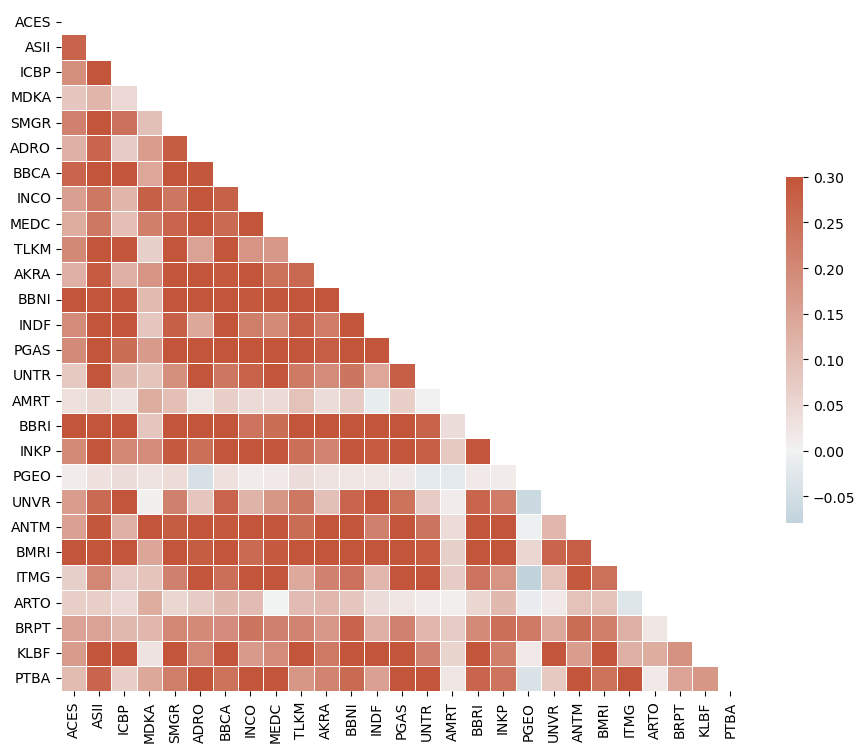

In [18]:
cov_matrix = train_df.cov()

# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Generate a mask for the upper triangle 
mask = np.triu(np.ones_like(cov_matrix, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(cov_matrix, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

Covariance takeaways 
- PGEO, AMRT, ARTO seems to have pretty low covariance with everything else -> Could be interesting to isolate profit tests on these assets
- PGEO AMRT and Arto seems to have pretty low contributions 

In [34]:
def pcap(norm_returns, p=0.30):
    """
    PCA with denoising factor p -> (1-p) variance
    
    :param norm_returns: Dataframe of normalized returns 
    :param p: Maximum number of noise to extract/remove from the data
    :return:  PCA object, explained variance ratios, and data with reduced dimensionality   
    """
    # Compute covariance matrix
    cov_matrix = norm_returns.cov()
    
    # Eigendecomposition of the variables into eigenvalues, eigenvectors
    
    eigenvalues, eigenvectors = np.linalg.eig(cov_matrix)
    
    # Sort eigenvalues and eigenvectors in descending order
    idx = eigenvalues.argsort()[::-1]
    eigenvalues = idx
    eigenvectors = eigenvectors[:, idx]
    
    # calculate cumulative explained variance ratio
    total_variance = np.sum(eigenvalues)
    cumulative_variance_ratio = np.cumsum(eigenvalues) / total_variance 
    
    # Determine the number of components to keep 
    k = np.argmax(cumulative_variance_ratio >= (1 - p )) + 1
    
    # Create PCA object and fit
    pca = PCA(n_components=k)
    reduced_data = pca.fit_transform(norm_returns)
    
    return pca, cumulative_variance_ratio, reduced_data

In [35]:
type(pca.explained_variance_ratio_)

numpy.ndarray

In [45]:
import numpy as np
from hmmlearn import hmm

def train_and_select_hmm(factor_returns, max_states=8):
    """
    Train HMM models with different numbers of states and select the best one based on AIC
    
    :param factor_returns: PCA factor returns
    :param max_states: Maximum number of states to consider
    :return: Best HMM model
    """
    best_model = None
    best_aic = np.inf

    for n_states in range(2, max_states + 1):
        model = hmm.GaussianHMM(n_components=n_states, covariance_type="diag", n_iter=100)

        try:
            model.fit(factor_returns)
            # Calculate AIC manually
            log_likelihood = model.score(factor_returns)
            n_params = n_states * (n_states - 1) + 2 * n_states * factor_returns.shape[1] - 1
            aic = -2 * log_likelihood + 2 * n_params

            if aic < best_aic:
                best_aic = aic
                best_model = model
        except:
            continue

    return best_model

# Example usage (assuming `reduced_data` is defined)
# reduced_data should be your PCA factor returns data
best_hmm = train_and_select_hmm(reduced_data)


In [47]:
best_hmm

GaussianHMM(n_components=8, n_iter=100)

In [48]:
def evaluate_performance(returns, strategy_returns):
    """
    Evaluate the performance of a trading strategy
    
    :param returns: Benchmark returns (buy-and-hold)
    :param strategy_returns: Strategy returns
    :return: Performance metrics
    """
    # Calculate winning probability
    winning_prob = np.mean(strategy_returns > 0)

    # Calculate annualized Sharpe ratio
    sharpe_ratio = np.sqrt(52) * strategy_returns.mean() / strategy_returns.std()

    # Calculate cumulative returns
    cumulative_returns = (1 + strategy_returns).cumprod()

    return winning_prob, sharpe_ratio, cumulative_returns

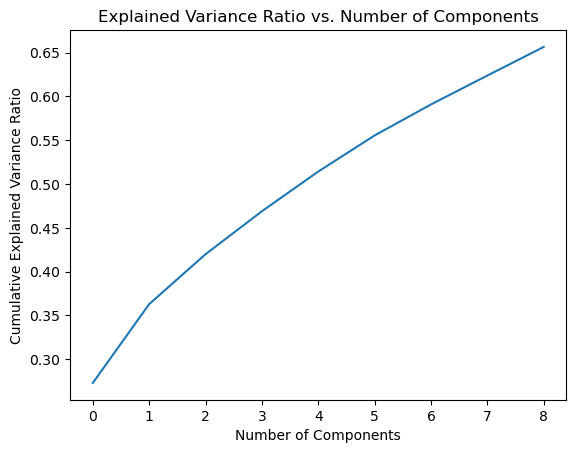

In [31]:
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.show()